### **SPLEX PROJECT: Legendary predictions based on Pokémon stats**
*LEGOFFIC LIAM and ZHONG YANN*

This project is a data science exploration project in which we seek to use fundamental methods in data science analysis, most notably clustering and dimensionality reduction, in order to analyse and predict whethere "Pokémon", inhabitants of one of the world's greatest grossing franchises, are legendary or not. Moreover, we would also like to answer other questions that pertain to the correlation of a Pokémon's stats with itself - are its stats predictable enough to guess, based on one or two stats?

Currently, the fundamental questions we seek to answer are:
- Can we infer a Pokémon's legendary status from its base stat total? (likely, yes)
- Can we infer a Pokémon's legendary status from its individual stats (hard to say)
- Can we infer a Pokémon's legendary status from its competitive usage tiering? (OU, UU, etc. To be implemented if we have sufficient time)
- Can we infer a Pokémon's name from its base stat total and its belonging to either group? (Prediction)
- Do Pokémon's attack stats correlate with their defense stats?
- Do Pokémon's special attack stats correlate with their special defense stats?
- Do Pokémon's HP stats anti-correlate with their speed stats? ("Fat" Pokémon)

With more questions to come. 

Todo:
- Answer the questions above
- Incorporate OU and Ubers stats into csv
- Clustering methods: is there a method to the madness? Can "logical" groups form?
- Dimensionality reduction? => UMAP, t-SNE

In [7]:
# Imports
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 100    

In [3]:
# Read in input file
data = pd.read_csv('Pokemon.csv')
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


### STEP 1: Visualising the dataset

Before anything, we would like to visualise the rough spread of the Pokémon's base stat totals, as well as individual stats, over a density plot. 
This should enable us to have a global idea of what the general spread of stats, as well as outliers, is.

In [5]:
# Split legendaries and non-legendaries into two datasets
legendaries = data[data['Legendary']==True]
plebians = data[data['Legendary']==False]

#legendaries
#plebians

The average base stat total for legendaries and non legendaries is respectively 630.2666666666667 and 414.9131034482759


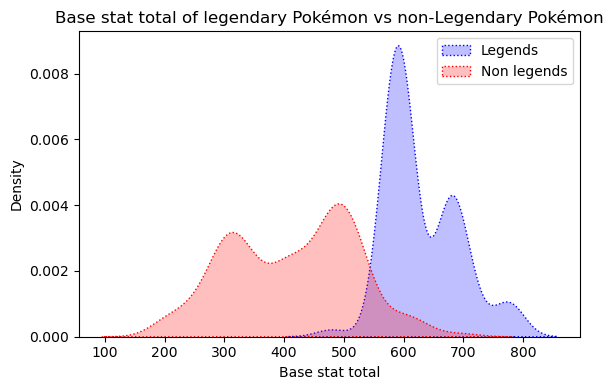

In [8]:
# Calculate average base stats
avg_l_base = sum(legendaries["Total"])/len(legendaries)
avg_p_base = sum(plebians["Total"])/len(plebians)

print("The average base stat total for legendaries and non legendaries is respectively "+ str(avg_l_base) + " and " + str(avg_p_base))

# Append base stats into list
l_base_list = []
p_base_list = []

for base in legendaries["Total"]:
    l_base_list.append(base)
for base in plebians["Total"]:
    p_base_list.append(base)

# Density plot
fig, ax = plt.subplots()
sns.kdeplot(l_base_list,shade=True,color="blue",label="Legends",linestyle ="dotted")
sns.kdeplot(p_base_list,shade=True,color="red",label="Non legends",linestyle ="dotted")
plt.title("Base stat total of legendary Pokémon vs non-Legendary Pokémon")
plt.xlabel("Base stat total")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()